In [16]:
import pandas as pd
import math
from scipy.io import loadmat
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import yasa
from sklearn.pipeline import Pipeline
from mne.decoding import CSP
from sklearn.model_selection import ShuffleSplit, cross_val_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics 
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler

annots = loadmat('P1_high1.mat')
trig = annots['trig']
eeg = annots['y']
events = trig
# events = np.squeeze(events.values.tolist())
data = eeg

print(events.shape, data.shape)

#fs=annots['fs'].squeeze()
fs=256
window_size = 40
channels = 8

(38976, 1) (38976, 8)


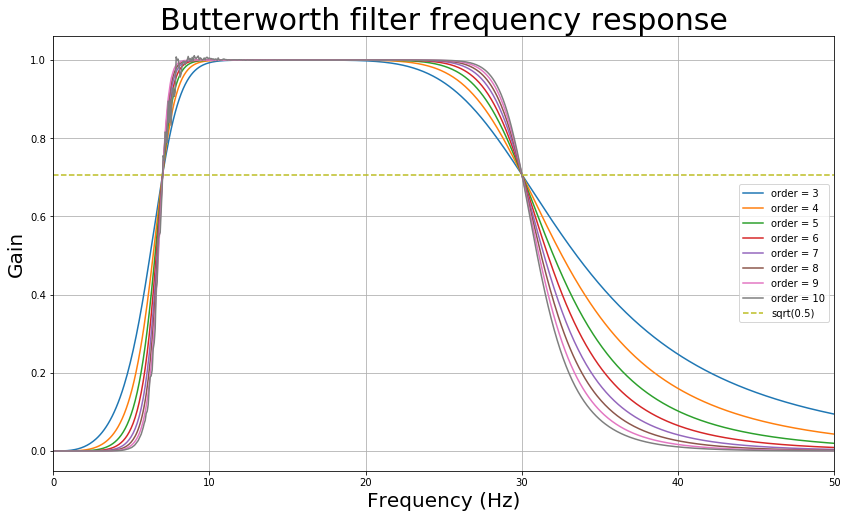

In [2]:
margin = 0
from scipy.signal import welch, freqz, butter, filtfilt

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y


# Plot frequency response, spectrum for unfiltered, test it on C3

# Define band
low = 7
high = 30

# Frequency response
plt.figure(1, figsize=(14, 8))
plt.clf()
for order in [3, 4, 5, 6, 7, 8, 9, 10]:
    b, a = butter_bandpass(low-margin, high+margin, fs, order=order)
    w, h = freqz(b, a, worN=2000)
    plt.plot((fs * 0.5 / np.pi) * w, abs(h), label="order = %d" % order)

plt.plot([0, 0.5 * fs], [np.sqrt(0.5), np.sqrt(0.5)],
         '--', label='sqrt(0.5)')
plt.title("Butterworth filter frequency response", fontsize=30)
plt.xlabel('Frequency (Hz)', fontsize=20)
plt.xlim([0, 50])
plt.ylabel('Gain', fontsize=20)
plt.grid(True)
plt.legend(loc='best')

In [3]:
non_target = np.zeros((channels, window_size))
target = np.zeros((channels, window_size))

non_target_count = 0 
target_count = 0

avg_non_target = np.zeros((channels, window_size))
avg_target = np.zeros((channels, window_size))

for i in range(events.shape[0]):
    if (events[i] == 1):
        non_target_count += 1
        trial = data[i: i + window_size, :].T
        non_target = np.append(non_target, trial, axis=1)
        avg_non_target += trial
        
    elif (events[i] == 2):
        target_count += 1
        trial = data[i: i + window_size, :].T
        target = np.append(target, trial, axis=1)
        avg_target += trial
    
    
avg_non_target /= non_target_count
non_target = non_target[:, window_size:]

avg_target /= target_count
target = target[:, window_size:]

all_trials = np.append(target, non_target, axis=1)

print(non_target.shape, all_trials.shape, target_count, non_target_count)

(8, 2400) (8, 4800) 60 60


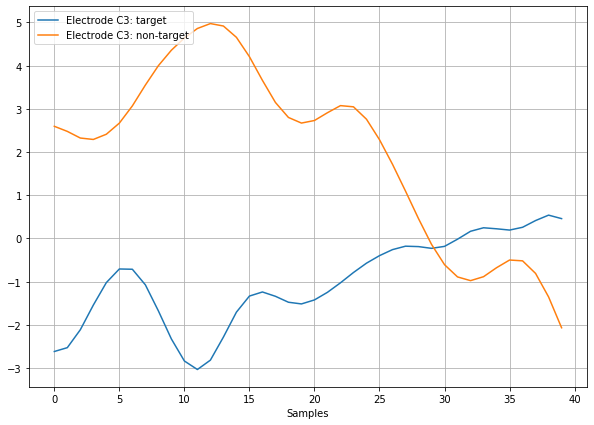

In [4]:
# plot
time = [i for i in range(window_size)]

plt.figure(1, figsize=(10, 7))
plt.clf()
plt.plot(time, avg_target[1, :], label='Electrode C3: target')
plt.plot(time, avg_non_target[1, :], label='Electrode C3: non-target' )

plt.xlabel('Samples')
plt.grid(True)
plt.axis('tight')
plt.legend(loc='upper left')

plt.show()

In [5]:
#data = all_trials[:, b-window_size:b]
#data.shape

In [6]:
#yasa.bandpower(data,sf=256)['TotalAbsPow']

In [7]:
# Create function to process eeg
'''
b = window_size
bp_trials = np.zeros((8, 1))

while (b <= all_trials.shape[1]):
    data = all_trials[:, b-window_size:b]
    data_bp = yasa.bandpower(data, fs, relative=False)['TotalAbsPow']
    data_bp = data_bp.values.reshape((data_bp.shape[0], 1))
    bp_trials = np.append(bp_trials, data_bp, axis=1)
    
    b += 35
bp_trials = bp_trials[:, 1:]
print(bp_trials.shape)
print(bp_trials) '''

"\nb = window_size\nbp_trials = np.zeros((8, 1))\n\nwhile (b <= all_trials.shape[1]):\n    data = all_trials[:, b-window_size:b]\n    data_bp = yasa.bandpower(data, fs, relative=False)['TotalAbsPow']\n    data_bp = data_bp.values.reshape((data_bp.shape[0], 1))\n    bp_trials = np.append(bp_trials, data_bp, axis=1)\n    \n    b += 35\nbp_trials = bp_trials[:, 1:]\nprint(bp_trials.shape)\nprint(bp_trials) "

In [8]:

# Create function to process eeg
b = 200
bp_trials = np.zeros((8, 1))

while (b <= all_trials.shape[1]):
    data_bp = all_trials[:, b-65:b]
    data_bp = yasa.bandpower(data_bp, fs, relative=False)['TotalAbsPow']
    data_bp = data_bp.values.reshape((data_bp.shape[0], 1))
    bp_trials = np.append(bp_trials, data_bp, axis=1)
    
    b += 10
    
bp_trials = bp_trials[:, 1:]
print(bp_trials.shape)
print(bp_trials)

C:\Users\LakshaySahni\Anaconda3\envs\tf2\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 1024 is greater than input length  = 65, using nperseg = 65
  .format(nperseg, input_length))


(8, 461)
[[ 50.9307169   56.41091598  71.75102762 ...  99.59772108  73.95680237
   80.8212251 ]
 [ 49.42068983  48.28067986  47.11379462 ...  96.68211125  81.3596932
   84.36220793]
 [ 43.49742523  61.04486606  91.09207956 ...  79.8536149   64.69340834
   62.43111834]
 ...
 [ 53.7448935   60.51875548  73.94270259 ...  74.24543185  65.34431258
   66.79410973]
 [ 86.10477881  92.66269283 135.3731742  ...  96.48381583 100.14837081
  104.17040448]
 [ 45.36911415  54.9117689   74.65115068 ...  38.44655433  40.21115422
   53.74630943]]


In [9]:
y = np.concatenate((np.ones(int(all_trials.shape[1]/2)), np.zeros(int(all_trials.shape[1]/2))))
print(y.shape)

(4800,)


[[661  68]
 [ 42 669]]


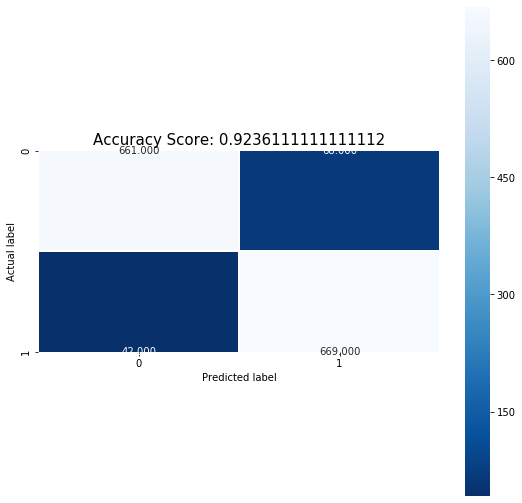

In [10]:
# classify

x_train, x_test, y_train, y_test = train_test_split(all_trials.T, y, test_size=0.3, shuffle=True, random_state=1)

scaler = StandardScaler()
scaler.fit(x_train)    
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

model = MLPClassifier(activation='relu', 
                      hidden_layer_sizes=(300, 150,50), 
                      alpha=0.0003,
                      learning_rate='adaptive')
model.fit(x_train, y_train)

# Make predictions on entire test set
predictions = model.predict(x_test)

# Use score method to get accuracy of model
score = model.score(x_test, y_test)

# Confusion matrix
cm = metrics.confusion_matrix(y_test, predictions)
print(cm)

# Plot confusion matrix
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {1}'.format("Neural Net", score)
plt.title(all_sample_title, size = 15);

[[420 309]
 [271 440]]


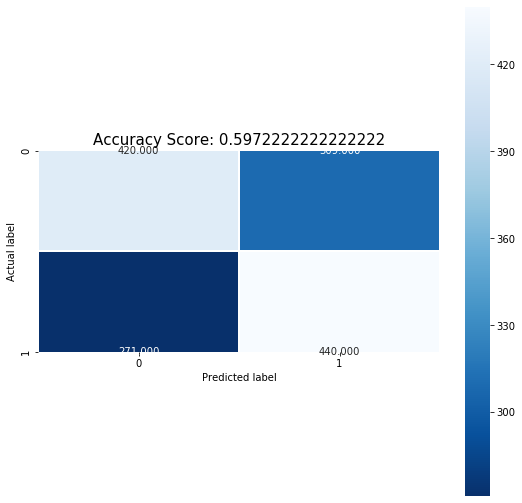

In [12]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
model = LinearDiscriminantAnalysis()
model.fit(x_train, y_train)

# Make predictions on entire test set
predictions = model.predict(x_test)

# Use score method to get accuracy of model
score = model.score(x_test, y_test)

# Confusion matrix
cm = metrics.confusion_matrix(y_test, predictions)
print(cm)

# Plot confusion matrix
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {1}'.format("Neural Net", score)
plt.title(all_sample_title, size = 15);

[[494 235]
 [188 523]]


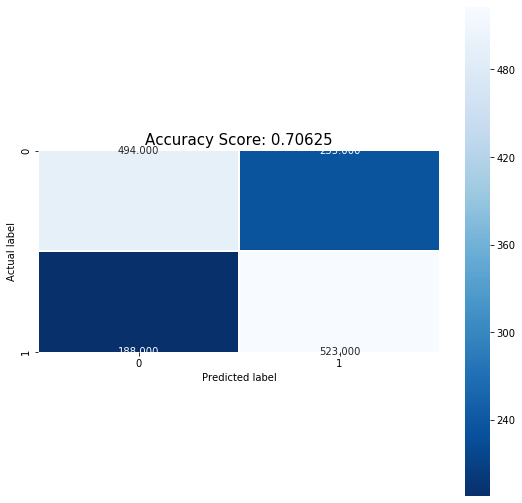

In [13]:
n_neighbors=33
weights = 'uniform'
model = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights)
model.fit(x_train, y_train)
# Make predictions on entire test set
predictions = model.predict(x_test)

# Use score method to get accuracy of model
score = model.score(x_test, y_test)

# Confusion matrix
cm = metrics.confusion_matrix(y_test, predictions)
print(cm)

# Plot confusion matrix
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {1}'.format("Neural Net", score)
plt.title(all_sample_title, size = 15);

[[320 409]
 [145 566]]


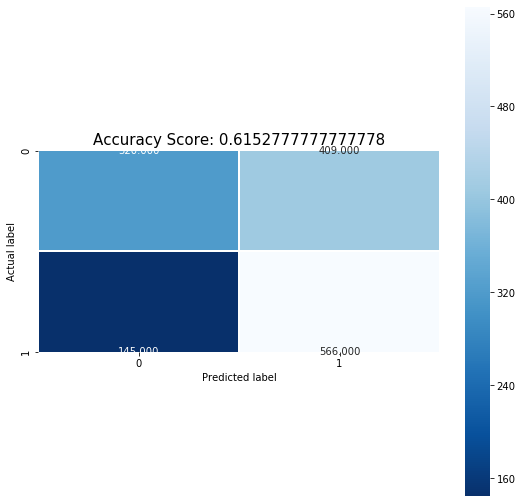

In [14]:
# %% SVM

model = SVC(kernel='poly')
model.fit(x_train,y_train)
predictions = model.predict(x_test)

# Use score method to get accuracy of model
score = model.score(x_test, y_test)

# Confusion matrix
cm = metrics.confusion_matrix(y_test, predictions)
print(cm)

# Plot confusion matrix
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {1}'.format("Neural Net", score)
plt.title(all_sample_title, size = 15);

[[518 211]
 [126 585]]


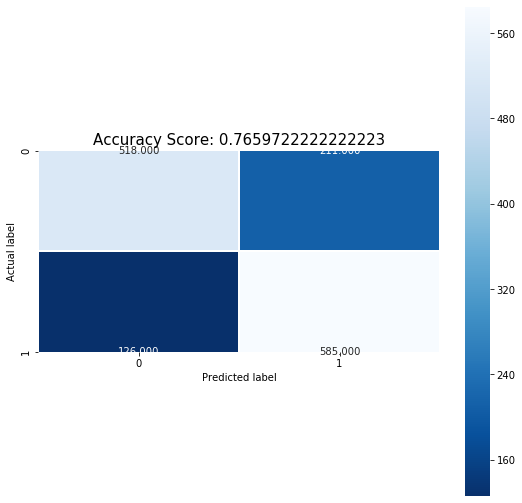

In [17]:
# %% Random Forest Classifier

model = RandomForestClassifier(max_depth=15, random_state=0)
model.fit(x_train, y_train)

predictions = model.predict(x_test)

# Use score method to get accuracy of model
score = model.score(x_test, y_test)

# Confusion matrix
cm = metrics.confusion_matrix(y_test, predictions)
print(cm)

# Plot confusion matrix
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {1}'.format("Neural Net", score)
plt.title(all_sample_title, size = 15);